In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import tqdm
from sklearn.preprocessing import RobustScaler

train_df = pd.read_csv('train.csv')

#get equal amount of 1 and 0 targets
first_class = train_df[train_df['TARGET']==1].iloc[:2500,:]
zero_class = train_df[train_df['TARGET']==0].iloc[:2500,:]
train_df = pd.concat([zero_class, first_class])
train_df = shuffle(train_df)
train_df.drop('ID',axis=1,inplace=True)
# 1
print('train_df_shape = ',train_df.shape)

train_df_shape =  (5000, 370)


In [2]:
non_unique_columns = []
for column in train_df.columns[:-1]:
    unique_percent = len(train_df[column].unique())/len(train_df)
    if unique_percent<0.1:
        non_unique_columns.append(column)
len(non_unique_columns)

train_df = train_df.drop(non_unique_columns,axis=1)
#In dataset we haven't nan values, so there is no need to fillna, but let it be)))
pct_null = (train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
pct_null[pct_null>0]
train_df = train_df.fillna(train_df.median())
# RobustScaler fit well, when we have outliers, which we don't want to remove. So it can scale our data despite them
robust_scaler = RobustScaler()
train_df.iloc[:,:-1] = robust_scaler.fit_transform(train_df.iloc[:,:-1])
Y_train=train_df.iloc[:,-1]
X_train=train_df.iloc[:,:-1]
print(X_train.shape)
print(Y_train.shape)

(5000, 14)
(5000,)


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [4]:
import numpy as np 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data_utils
import torchvision.datasets as dataset
import torch

batch_size = 12
num_workers = 4

x_train = torch.tensor(x_train.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32))
x_valid = torch.tensor(x_valid.values.astype(np.float32))
y_valid = torch.tensor(y_valid.values.astype(np.float32))

trainset = data_utils.TensorDataset(x_train, y_train)
validset = data_utils.TensorDataset(x_valid, y_valid)

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=True)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=True)

In [5]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
                                nn.Linear(x_train.shape[1], x_train.shape[1]//2),
                                nn.LeakyReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(x_train.shape[1]//2, 2)
                                )

    def forward(self, x):
        return self.model(x)

model = NN()

In [6]:
def train(model, train_loader, valid_loader, criterion, optimizer):
    for epoch in range(1, 200):
        train_loss = []
        for _, (data, target) in enumerate(train_loader):
            target = target.type(torch.LongTensor)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = []
        for _, (data, target) in enumerate(valid_loader):
            target = target.type(torch.LongTensor)
            output = model(data)
            loss = criterion(output, target)
            val_loss.append(loss.item()) 
        if epoch%20==0:
            print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}")
        model.train()
        
    return model

In [7]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
model_out = train(model, trainloader, validloader, criterion, 
                              optimizer)

Epoch 20, train loss: 0.6925, valid loss: 0.9397
Epoch 40, train loss: 0.6740, valid loss: 0.9799
Epoch 60, train loss: 0.6545, valid loss: 0.8488
Epoch 80, train loss: 0.6483, valid loss: 0.7265
Epoch 100, train loss: 0.6359, valid loss: 0.6955
Epoch 120, train loss: 0.6365, valid loss: 0.7229
Epoch 140, train loss: 0.6357, valid loss: 0.7315
Epoch 160, train loss: 0.6299, valid loss: 0.7889
Epoch 180, train loss: 0.6256, valid loss: 0.7284


In [9]:
model.eval()
from sklearn.metrics import f1_score

predicts = []
targets = []
with torch.no_grad():
  for data, target in validloader:
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    target = target.cpu().numpy()
    for pred in predicted:
        predicts.append(pred)
    for t in target:
        targets.append(t)

print("f1 score = ",f1_score(targets, predicts, average='micro'))

f1 score =  0.658


Random forest f1 score was 0.72

TASK 2

In [15]:
import os ,fnmatch
import numpy as np 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data_utils
import torchvision.datasets as dataset
import torch
import random


def find_files(directory : str, pattern : str):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename

images_list = list(find_files('archive', '*.jpg'))

In [16]:
valid_list_0 = []
valid_list_1 = []
valid_list_2 = []
for image_path in images_list:
    if 'hammerhead' in image_path:
        if len(valid_list_0)==10:
            continue
        valid_list_0.append(image_path)
        
    elif 'whale' in image_path:
        if len(valid_list_1)==10:
            continue
        valid_list_1.append(image_path)

    elif 'white' in image_path:
        if len(valid_list_2)==10:
            continue
        valid_list_2.append(image_path)

valid_list = valid_list_0+valid_list_1+valid_list_2
random.shuffle(valid_list)

In [17]:
for path in valid_list:
    images_list.remove(path)

train_list = images_list
random.shuffle(train_list)

In [18]:
import cv2
import albumentations as A
from albumentations import pytorch as AT

data_transforms = A.Compose([
    A.Resize(480, 480),                         
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    A.CenterCrop(256,256, p = 0.1),
    A.Resize(480, 480),
    AT.ToTensor()
    ])

data_transforms_test = A.Compose([
    A.Resize(480, 480),
    AT.ToTensor()
    ])

class DatasetLoader(Dataset):
  def __init__(self,image_list,transform=None):
        self.image_list = image_list
        self.transform = transform

  def __len__(self):
        return len(self.image_list)

  def __getitem__(self, idx: int):       
        image_path = self.image_list[idx]
            
        image = cv2.imread(image_path)
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print(image_path)
            print(image.shape)
        if 'hammerhead' in image_path:
            label = 0
        elif 'whale' in image_path:
            label = 1
        elif 'white' in image_path:
            label = 2
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [19]:
batch_size = 5

trainset = DatasetLoader(image_list=train_list, transform = data_transforms)
validset = DatasetLoader(valid_list, transform=data_transforms_test)

trainloader = DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=True)

print(len(trainloader),len(validloader))

69 6


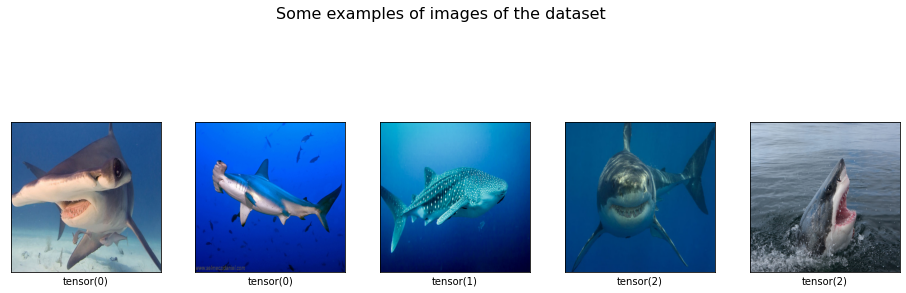

In [20]:
samples, labels = next(iter(validloader))
fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(labels[i])
plt.show()

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import f1_score
import torchvision
import tqdm

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b2')
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 3)

def train_model(model, train_loader, valid_loader, criterion, optimizer, sheduler, n_epochs):
    model.to(device)
    train_loss = []
    # количество эпох
    for epoch in range(1, n_epochs+1):
        train_loss = []
        for data, target in tqdm.tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        sheduler.step(np.mean(train_loss))
        predicts_list = []
        targets_list = []
        model.eval()
        with torch.no_grad():
            for data, target in valid_loader:
                data = data.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted.cpu().detach().numpy()
                targets = target.cpu().numpy()
                for pred in predicted:
                    predicts_list.append(pred)
                for target in targets:
                    targets_list.append(target)
                    
        model.train()
        print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid f1 score: {f1_score(targets_list, predicts_list, average=None)}")

        
    return model

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)
model_out = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler ,n_epochs=30)

100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 1, train loss: 0.7963, valid f1 score: [0.70588235 0.9        0.69565217]


100%|██████████| 69/69 [00:25<00:00,  2.72it/s]


Epoch 2, train loss: 0.7065, valid f1 score: [0.7 0.8 0.6]


100%|██████████| 69/69 [00:26<00:00,  2.61it/s]


Epoch 3, train loss: 0.7879, valid f1 score: [0.55555556 0.7826087  0.42105263]


100%|██████████| 69/69 [00:26<00:00,  2.61it/s]


Epoch 4, train loss: 0.7118, valid f1 score: [0.6        0.88888889 0.54545455]


100%|██████████| 69/69 [00:25<00:00,  2.70it/s]


Epoch 5, train loss: 0.6661, valid f1 score: [0.7826087  0.7826087  0.42857143]


100%|██████████| 69/69 [00:26<00:00,  2.65it/s]


Epoch 6, train loss: 0.6642, valid f1 score: [0.55555556 0.9        0.54545455]


100%|██████████| 69/69 [00:26<00:00,  2.63it/s]


Epoch 7, train loss: 0.6498, valid f1 score: [0.69230769 0.76190476 0.30769231]


100%|██████████| 69/69 [00:24<00:00,  2.84it/s]


Epoch 8, train loss: 0.6682, valid f1 score: [0.30769231 0.75       0.58064516]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 9, train loss: 0.6840, valid f1 score: [0.16666667 0.69565217 0.56      ]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 10, train loss: 0.6294, valid f1 score: [0.44444444 0.94736842 0.52173913]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 11, train loss: 0.5860, valid f1 score: [0.70588235 0.18181818 0.5625    ]


100%|██████████| 69/69 [00:26<00:00,  2.65it/s]


Epoch 12, train loss: 0.6087, valid f1 score: [0.66666667 0.82352941 0.63636364]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 13, train loss: 0.6733, valid f1 score: [0.625      0.64285714 0.375     ]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 14, train loss: 0.5722, valid f1 score: [0.7        0.69565217 0.35294118]


100%|██████████| 69/69 [00:25<00:00,  2.67it/s]


Epoch 15, train loss: 0.5732, valid f1 score: [0.64       0.69565217 0.33333333]


100%|██████████| 69/69 [00:25<00:00,  2.67it/s]


Epoch 16, train loss: 0.5787, valid f1 score: [0.53333333 0.9        0.64      ]


100%|██████████| 69/69 [00:26<00:00,  2.65it/s]


Epoch    17: reducing learning rate of group 0 to 2.0000e-04.
Epoch 17, train loss: 0.5772, valid f1 score: [0.44444444 0.84210526 0.52173913]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 18, train loss: 0.5365, valid f1 score: [0.76923077 0.84210526 0.4       ]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 19, train loss: 0.4211, valid f1 score: [0.76923077 0.88888889 0.5       ]


100%|██████████| 69/69 [00:25<00:00,  2.66it/s]


Epoch 20, train loss: 0.3836, valid f1 score: [0.71428571 0.82352941 0.4       ]


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Epoch 21, train loss: 0.4041, valid f1 score: [0.74074074 0.75       0.58823529]


100%|██████████| 69/69 [00:24<00:00,  2.84it/s]


Epoch 22, train loss: 0.3776, valid f1 score: [0.8        0.82352941 0.77777778]


100%|██████████| 69/69 [00:24<00:00,  2.85it/s]


Epoch 23, train loss: 0.3184, valid f1 score: [0.71428571 0.75       0.5       ]


100%|██████████| 69/69 [00:23<00:00,  2.97it/s]


Epoch 24, train loss: 0.2984, valid f1 score: [0.71428571 0.75       0.5       ]


100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


Epoch 25, train loss: 0.3373, valid f1 score: [0.71428571 0.75       0.5       ]


100%|██████████| 69/69 [00:23<00:00,  2.98it/s]


Epoch 26, train loss: 0.2670, valid f1 score: [0.71428571 0.75       0.5       ]


100%|██████████| 69/69 [00:23<00:00,  2.98it/s]


Epoch 27, train loss: 0.2736, valid f1 score: [0.75 0.75 0.7 ]


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


Epoch 28, train loss: 0.2514, valid f1 score: [0.54545455 0.75       0.45454545]


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Epoch 29, train loss: 0.2355, valid f1 score: [0.68965517 0.77777778 0.30769231]


100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


Epoch 30, train loss: 0.2570, valid f1 score: [0.76923077 0.77777778 0.5       ]


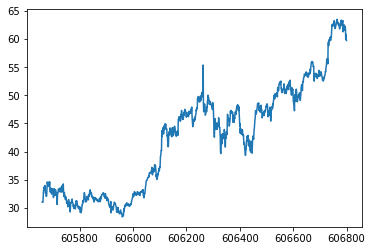

In [12]:
import pandas as pd

train_df = pd.read_csv('all_stocks_5yr.csv')

train_df = train_df[train_df['Name']=='ZTS']
train_df = train_df.drop(['Date','Open','High','Low','Volume','Name'],axis = 1)

plt.plot(train_df['Close'])
plt.show()

make time series stationary

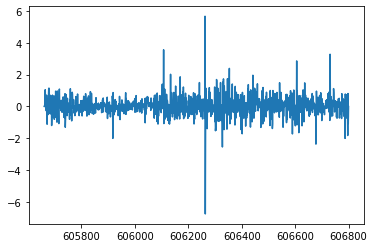

In [13]:
train_df['Close'] = train_df['Close'] - train_df['Close'].shift(1)
train_df = train_df.dropna()
train_df['Close'].plot()

In [14]:
def create_sequences(input_data, window):
    x = []
    y = []
    len_data = len(input_data)
    for i in range(len_data-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        x.append(train_seq)
        y.append(train_label)
    return x,y


seq_length = 30
x, y = create_sequences(train_df, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

class LSTM_model(nn.Module):
    
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        hiden_0 = torch.zeros(1, 1, self.hidden_layer_size).to(device)
        hiden_1 = torch.zeros(1, 1, self.hidden_layer_size).to(device)

        self.hidden_cell = (hiden_0,hiden_1)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM_model()

model = model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epochs = 20

for i in tqdm.tqdm(range(epochs)):
    loss = []
    for index, data in enumerate(trainX):
        target = trainY[index]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        hiden_0 = torch.zeros(1, 1, model.hidden_layer_size).to(device)
        hiden_1 = torch.zeros(1, 1, model.hidden_layer_size).to(device)
        model.hidden_cell = (hiden_0,hiden_1)

        y_pred = model(data)

        single_loss = loss_function(y_pred, target)
        single_loss.backward()
        optimizer.step()
        loss.append(single_loss.item()) 
    mean_loss = np.mean(loss)

    print(f'loss: {single_loss.item():10.8f}')

  5%|▌         | 1/20 [00:01<00:25,  1.32s/it]

loss: 0.21991350


 10%|█         | 2/20 [00:02<00:25,  1.39s/it]

loss: 0.22997192


 15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

loss: 0.23655024


 20%|██        | 4/20 [00:05<00:20,  1.30s/it]

loss: 0.24043378


 25%|██▌       | 5/20 [00:06<00:20,  1.37s/it]

loss: 0.24233986


 30%|███       | 6/20 [00:08<00:19,  1.37s/it]

loss: 0.24344936


 35%|███▌      | 7/20 [00:09<00:19,  1.46s/it]

loss: 0.24497178


 40%|████      | 8/20 [00:11<00:17,  1.46s/it]

loss: 0.24830249


 45%|████▌     | 9/20 [00:12<00:16,  1.49s/it]

loss: 0.25564995


 50%|█████     | 10/20 [00:14<00:14,  1.41s/it]

loss: 0.26144791


 55%|█████▌    | 11/20 [00:15<00:12,  1.37s/it]

loss: 0.25309896


 60%|██████    | 12/20 [00:17<00:11,  1.48s/it]

loss: 0.23671249


 65%|██████▌   | 13/20 [00:18<00:10,  1.54s/it]

loss: 0.23465517


 70%|███████   | 14/20 [00:20<00:09,  1.51s/it]

loss: 0.08332253


 75%|███████▌  | 15/20 [00:21<00:07,  1.44s/it]

loss: 0.06309082


 80%|████████  | 16/20 [00:22<00:05,  1.42s/it]

loss: 0.07113261


 85%|████████▌ | 17/20 [00:24<00:04,  1.50s/it]

loss: 0.10043927


 90%|█████████ | 18/20 [00:26<00:03,  1.56s/it]

loss: 0.14046715


 95%|█████████▌| 19/20 [00:27<00:01,  1.46s/it]

loss: 0.15803443


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

loss: 0.11881965


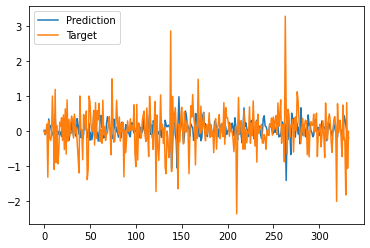

In [16]:
predictions = []
gt = []
for index, data in enumerate(testX):
        target = testY[index]
        data, target = data.to(device), target.to(device)
        y_pred = model(data)
        predictions.append(y_pred.cpu().detach().numpy().squeeze())
        gt.append(target.cpu().detach().numpy().squeeze())
        
plt.plot(predictions, label = 'Prediction')
plt.plot(gt, label = 'Target')

plt.legend()